In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from matplotlib.collections import LineCollection
from shapely.geometry import Point, Polygon, LineString
from os import path, listdir
import matplotlib.pyplot as plt
from pathlib import Path
import datetime


In [2]:
from main import get_graph, draw_graph

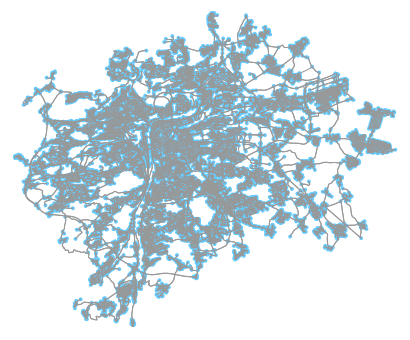

In [3]:
G = get_graph('Prague')

In [4]:
nodes_df, edges_df = ox.graph_to_gdfs(G)
nodes_df.crs = {'init': 'epsg:4326'} 
edges_df.crs = {'init': 'epsg:4326'} 
edges_df = edges_df[['u', 'v', 'length', 'geometry']]
nodes_df = nodes_df[['osmid', 'y', 'x',  'geometry']]
# 20828 nodes, 48397 edges


20828 48397


/home/olga/anaconda3/envs/vga/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [116]:
from sklearn.cluster import KMeans
data = [x for x in zip(nodes_df.x, nodes_df.y)]
kmeans = KMeans(n_clusters=50, random_state=0).fit(data)
centroids = kmeans.cluster_centers_


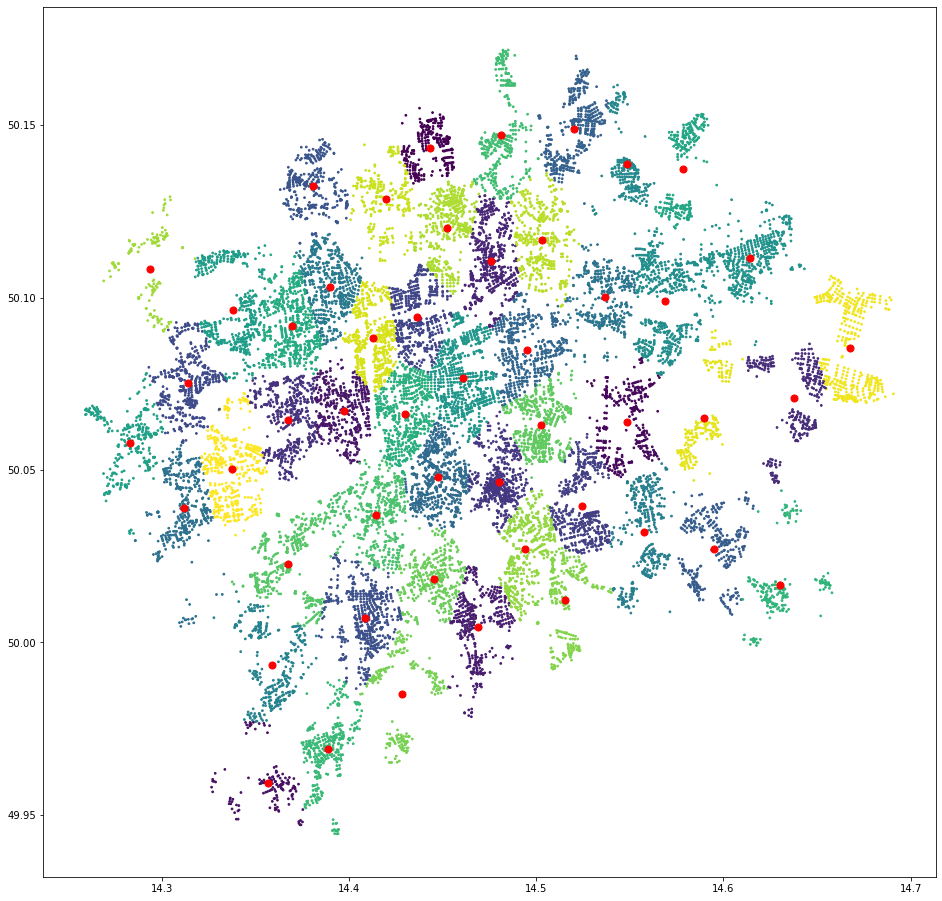

In [117]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter([x for x,_ in data], [y for _, y in data], c=kmeans.labels_, s=3, zorder=1)
ax.scatter([x for x,_ in centroids], [y for _, y in centroids], c='red', s=50, zorder=2)
plt.savefig('centroids.png')


In [ ]:
nodes_df['centroid_label'] = kmeans.labels_
centroids_df = pd.DataFrame(np.array([range(len(centroids)), [float(x) for x,_ in centroids], [float(y) for _, y in centroids]]).T,
                            columns=['label', 'x', 'y'])
centroids_df['label'] = centroids_df.label.apply(int)
# print(nodes_df.head())


   label          x          y                             geom   from_center
0      0  14.443119  50.143492  POINT (6895468.949 7251164.001)   9150.020636
1      1  14.548317  50.063876  POINT (6905148.173 7257516.016)   5110.335376
2      2  14.356627  49.959295  POINT (6914174.992 7241826.257)  14344.521942
3      3  14.397075  50.067020  POINT (6903120.265 7246553.923)   6055.556367
4      4  14.469058  50.004588  POINT (6910598.908 7250770.211)   6296.183113


In [121]:
# distance of the centroid nodes from the center
from shapely.geometry import box
nodes_proj = nodes_df.to_crs(epsg=3310)
bbox = box(*nodes_proj.unary_union.bounds)
centroid = bbox.centroid
centroids_gdf = gpd.GeoDataFrame(centroids_df, geometry=gpd.points_from_xy(centroids_df.x, centroids_df.y))
centroids_gdf = centroids_gdf.rename(columns={'geometry': 'geom'}).set_geometry('geom', crs=4326)
centroids_gdf.to_crs(epsg=3310, inplace=True)
centroids_gdf['from_center'] = centroids_gdf.geom.apply(lambda point : point.distance(centroid))
print(centroids_gdf.head())

   label          x          y                             geom   from_center
0      0  14.443119  50.143492  POINT (6895468.949 7251164.001)   9150.020636
1      1  14.548317  50.063876  POINT (6905148.173 7257516.016)   5110.335376
2      2  14.356627  49.959295  POINT (6914174.992 7241826.257)  14344.521942
3      3  14.397075  50.067020  POINT (6903120.265 7246553.923)   6055.556367
4      4  14.469058  50.004588  POINT (6910598.908 7250770.211)   6296.183113


In [114]:
# Metric projection to compute distances correctly 
# edges_proj = edges_df.to_crs(epsg=3310)
# nodes_proj = nodes_df.to_crs(epsg=3310)
# i = 0
# for u,v, d in G.edges(data=True):
#     print(u, v, d)
#     nu = nodes_proj.iloc[u].geometry
#     nv = nodes_proj.iloc[v].geometry
#     dist = nu.distance(nv)
#     print(d['length'], ' == ', dist)
#     i += 1
#     if i == 10: break
# check projection
# edges_df.to_crs(epsg=3310, inplace=True)
# edges_df['dist'] = edges_df.geometry.length
# print(edges_df[['length', 'dist']].head(10))

   label          x          y                             geom   from_center
0      0  14.443119  50.143492  POINT (6895468.949 7251164.001)   9150.020636
1      1  14.548317  50.063876  POINT (6905148.173 7257516.016)   5110.335376
2      2  14.356627  49.959295  POINT (6914174.992 7241826.257)  14344.521942
3      3  14.397075  50.067020  POINT (6903120.265 7246553.923)   6055.556367
4      4  14.469058  50.004588  POINT (6910598.908 7250770.211)   6296.183113


In [ ]:
# parse original txt file containing  286009 requests.
# request time (ms from 00:00), pickup latitude, pickup longitude, dropoff latitude, dropoff longitude
# separated by space

cols = ['time', 'pickup_lat', 'pickup_lon', 'dropoff_lat', 'dropoff_lon']
home = str(Path.home())
df = pd.read_csv(path.join(home, 'Downloads', 'trips.txt'), 
                 index_col=None, header=None, sep=' ', names=cols)
df.rename(columns={'time': 'time_ms'}, inplace=True)
df.sort_values(by='time_ms', inplace=True)
df['time'] = pd.to_datetime(df['time_ms'], unit='ms')  

df.to_csv('prague_df.csv', index=False)


In [129]:
# Read data from csv, create geodataframe
df = pd.read_csv('prague_df.csv', index_col=None, parse_dates=True)
trips0 = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_lon, df.pickup_lat))
trips0 = trips0.rename(columns={'geometry': 'pgeom'}).set_geometry('pgeom')
trips0['dgeom'] = gpd.points_from_xy(df.dropoff_lon, df.dropoff_lat)
trips0['hour'] = trips0['time_ms'].apply(lambda ms: int(ms//(60*60*1e3)))
trips0.crs = {'init': 'epsg:4326'} 
# print(print(gdf.shape))

/home/olga/anaconda3/envs/vga/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


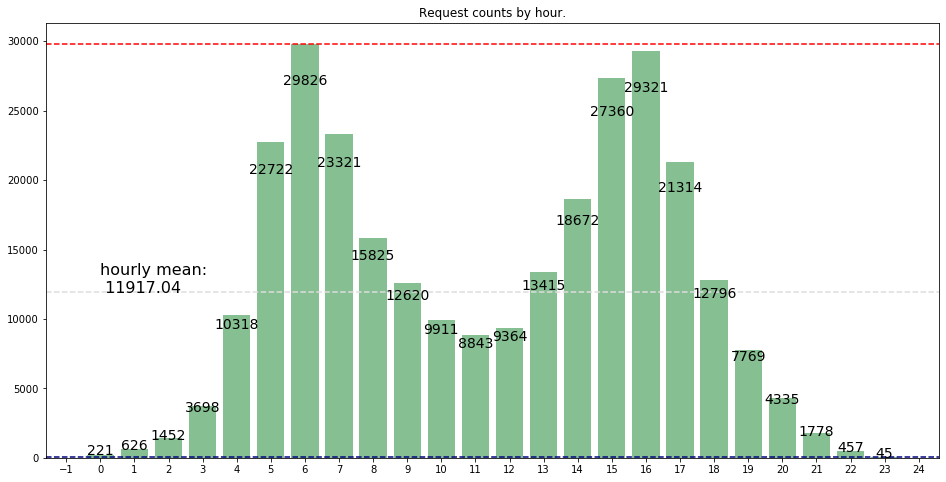

In [6]:
# number of trips by hour
counts = trips0.groupby(['hour']).size()
counts_df = pd.DataFrame(counts, columns=['counts'])
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.bar(counts_df.index.values, counts_df['counts'].values, label='request counts', color='#86bf91' )
for i, v in enumerate(counts_df.counts):
    ax.text(i, 0.9*v, '%s'% v, fontsize=14, ha='center')

mean = counts_df.counts.mean()
max = counts_df.counts.max()
min = counts_df.counts.min()
ax.axhline(y=mean, linestyle='dashed', alpha=1, color='#dddddd', zorder=1)
ax.text(0, mean, 'hourly mean:\n %.2f' % mean, fontsize=16)
ax.axhline(y=min, linestyle='dashed', alpha=1, color='navy', zorder=1)
ax.axhline(y=max, linestyle='dashed', alpha=1, color='red', zorder=1)
ax.set_title('Request counts by hour.')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
# plt.savefig('prague_hourly_stats.png', box_inches='tight')






In [8]:
# find nearest nodes for pickups and dropoffs
from scipy.spatial import cKDTree

tree = cKDTree(np.array(list(zip(nodes_df.geometry.x, nodes_df.geometry.y))))

In [ ]:
#pickup nodes
trips1 = trips0.set_geometry('pgeom')
dist, idx = tree.query(np.array(list(zip(trips1.pgeom.x, trips1.pgeom.y))), k=1)

gdf_pickup = pd.concat([trips1.reset_index(drop=True), nodes_df.loc[idx].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
gdf_pickup = gdf_pickup[['osmid', 'geometry', 'centroid_label']]
gdf_pickup.rename(columns={'osmid': 'pickup_node', 'geometry': 'pngeom',
                             'centroid_label': 'p_centroid'}, inplace=True)


In [ ]:
#dropoff nodes
trips1 = trips0.set_geometry('dgeom')
dist, idx = tree.query(np.array(list(zip(trips1.dgeom.x, trips1.dgeom.y))), k=1)

gdf_dropoff = pd.concat([trips1.reset_index(drop=True), nodes_df.loc[idx].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
gdf_dropoff = gdf_dropoff[['osmid', 'geometry', 'centroid_label']]
gdf_dropoff.rename(columns={'osmid': 'dropoff_node', 'geometry': 'pdgeom',
                             'centroid_label': 'd_centroid'}, inplace=True)

In [ ]:
#join back
# trips2 = trips1[['time_ms','time','pgeom', 'dgeom']]
trips2 = pd.concat([trips1, gdf_pickup, gdf_dropoff], axis=1)

# output_df = pd.DataFrame(trips2[['time_ms', 'pickup_lat' , 'pickup_lon', 'dropoff_lat', 'dropoff_lon',
#                                  'pickup_node', 'p_centroid', 'dropoff_node', 'd_centroid']])
# output_df.to_csv('trips_with_clusters.csv')


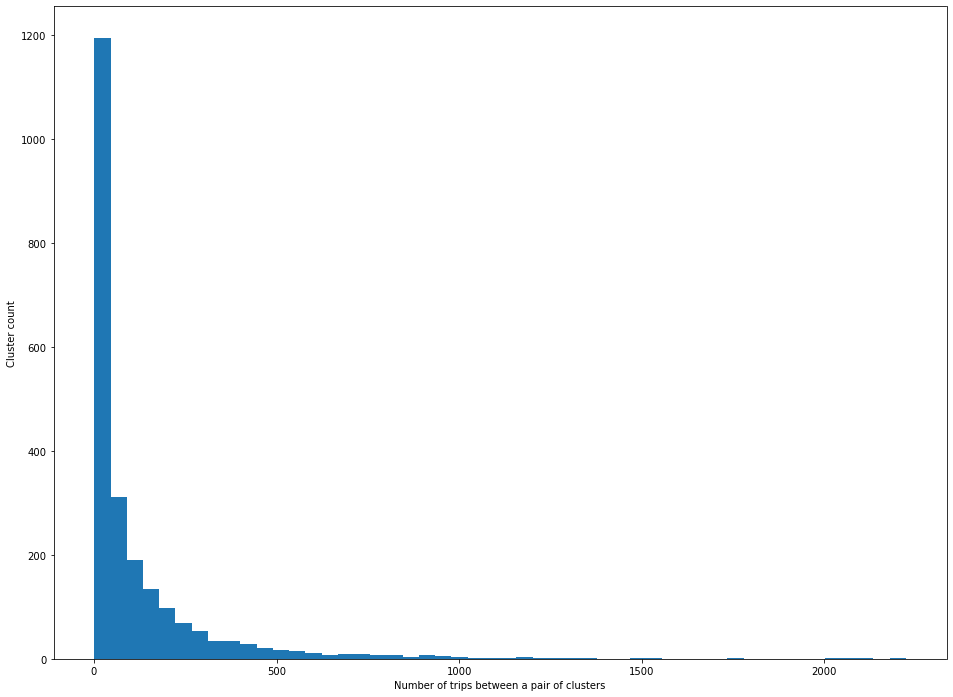

In [ ]:
# Count trips between pairs of clusters
trips_clust = trips2[['time_ms', 'p_centroid', 'd_centroid']]
counts = trips_clust.groupby(['p_centroid', 'd_centroid']).size().reset_index(name='count')
counts = pd.merge(counts, centroids_gdf, left_on='p_centroid', right_on='label')
counts.rename(columns={'x':'p_x', 'y':'p_y','from_center':'p_center','geom':'p_geom'}, inplace=True)
counts.drop(columns='label', inplace=True)
counts = pd.merge(counts, centroids_gdf, left_on='d_centroid', right_on='label')
counts.rename(columns={'x':'d_x', 'y':'d_y', 'from_center':'d_center','geom':'dgeom'}, inplace=True)
counts.drop(columns='label', inplace=True)
counts.crs = 'epsg:4326'

# print(counts.head())


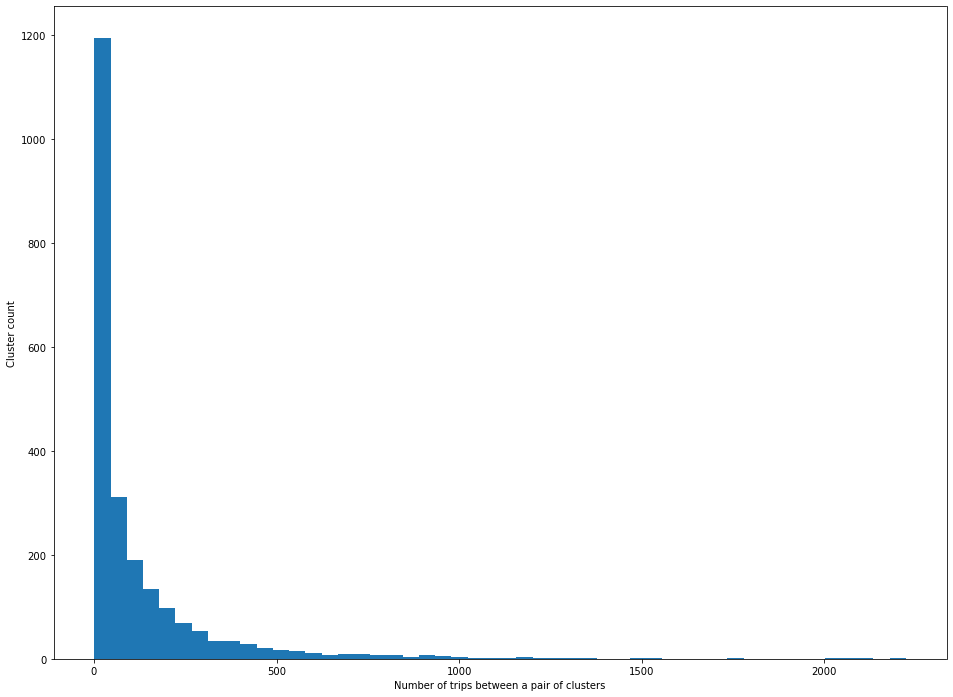

In [184]:
# counts.hist(by='count', bins=50, figsize=(16, 12))
fig, ax = plt.subplots(figsize=(16,12))
ax.hist(counts['count'].values, bins=50)
ax.set_xlabel('Number of trips between a pair of clusters')
ax.set_ylabel('Cluster count')
plt.savefig('cluster_hist.png')

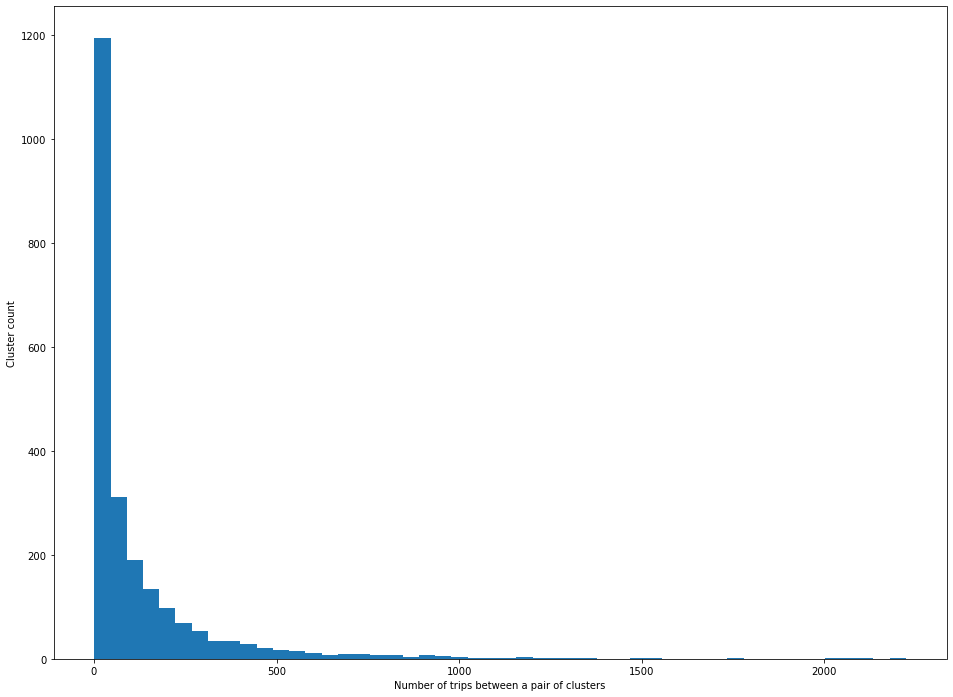

In [ ]:
# Inside one cluster
counts_incluster = counts[counts.p_centroid == counts.d_centroid]
counts_incluster.drop(columns=['d_centroid', 'd_x', 'd_y', 'd_center','dgeom'], inplace=True)
counts_incluster.rename(columns={'p_centroid':'centroid', 'p_x':'x', 'p_y':'y', 
                                 'p_geom':'geom', 'p_center':'center'}, inplace=True)
# between the clusters
counts_btwcluster = counts[counts.p_centroid != counts.d_centroid]


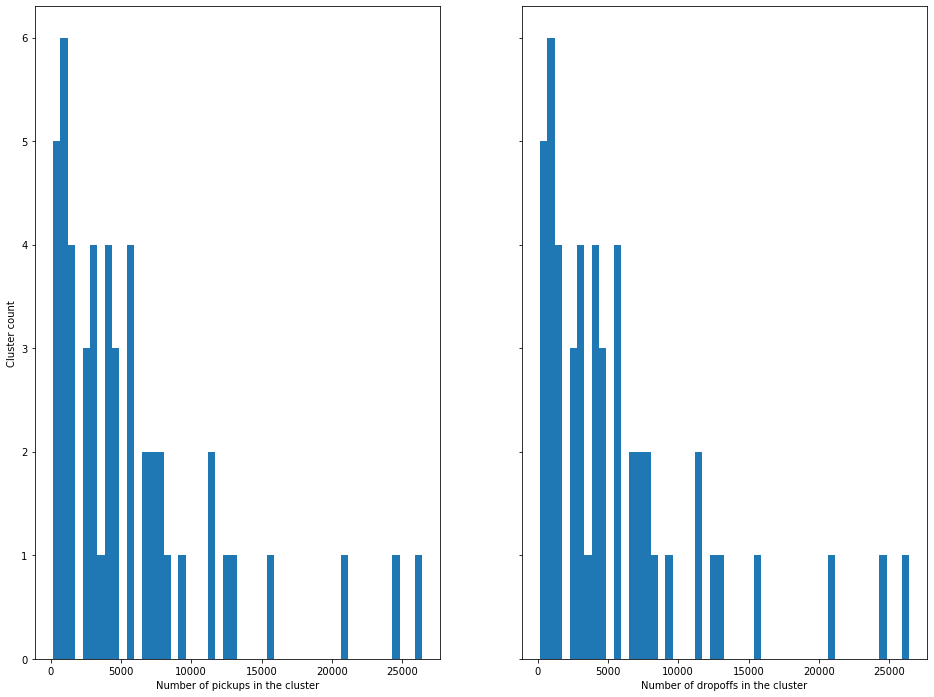

In [185]:
#pickup  and dropoff counts
trips_clust = trips2[['time_ms', 'hour', 'p_centroid', 'd_centroid']]
p_counts = trips_clust.groupby(['p_centroid']).size().reset_index(name='count')
d_counts = trips_clust.groupby(['d_centroid']).size().reset_index(name='count')
fig, axes = plt.subplots(1,2, figsize=(16,12), sharey=True)
ax = axes[0]
ax.hist(p_counts['count'].values, bins=50)
ax.set_xlabel('Number of pickups in the cluster')
ax.set_ylabel('Cluster count')
ax = axes[1]
ax.hist(d_counts['count'].values, bins=50)
ax.set_xlabel('Number of dropoffs in the cluster')

plt.savefig('cluster_pd_hist.png')


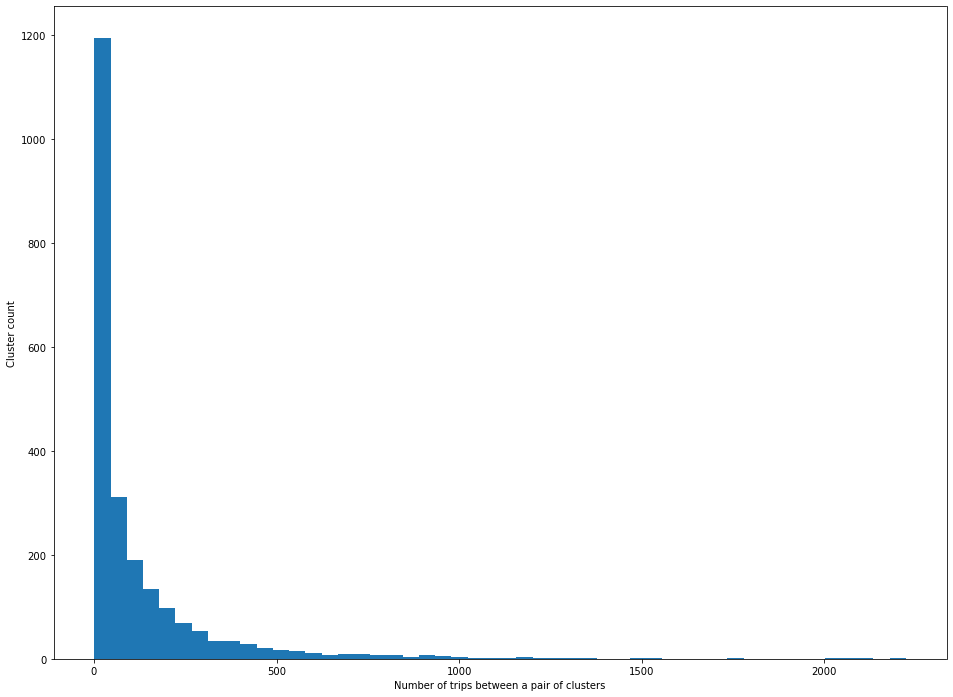

In [175]:
#Origins by clusters, hour by hour
trips_clust_hourly = trips2[['time_ms', 'hour', 'p_centroid', 'd_centroid']]
counts_h = trips_clust_hourly.groupby(['p_centroid', 'd_centroid', 'hour']).size().reset_index(name='count')
counts_h = pd.merge(counts_h, centroids_gdf, left_on='p_centroid', right_on='label')
counts_h.rename(columns={'x': 'p_x', 'y': 'p_y', 'from_center': 'p_center', 'geom': 'p_geom'}, inplace=True)
counts_h.drop(columns='label', inplace=True)
counts_h = pd.merge(counts_h, centroids_gdf, left_on='d_centroid', right_on='label')
counts_h.rename(columns={'x': 'd_x', 'y': 'd_y', 'from_center': 'd_center','geom': 'dgeom'}, inplace=True)
counts_h.drop(columns='label', inplace=True)
counts_h.crs = 'epsg:4326'

# print(counts_h.head())
# out = pd.DataFrame(counts_h)
# out.to_csv('hourly_cluster_counts.csv')


In [ ]:
# project dataframe with origin geometry
counts_proj = counts_gdf.to_crs(epsg=3310)
# project destination geometry

counts_proj.set_geometry('dgeom', inplace=True, crs=4326)
counts_proj.to_crs(epsg=3310, inplace=True)
counts_proj['centroid_dist_m'] = counts_proj.apply(lambda r : r.pgeom.distance(r.dgeom), axis=1)
counts_proj['v_x'] = counts_proj.d_x - counts_proj.p_x
counts_proj['v_y'] = counts_proj.d_y - counts_proj.p_y
print(counts_proj.head())


[  70  191   17  535  136  368   42  289  160  391 1272  297  277  165
   49  243  505  772  156  138  684  228  110   89  330  307 2223  214
   38   29  364 2050   87   67  148  177  355  459   74   47  424   19
  342  562  215 1149   75  677    9   12]


In [103]:
# colors = incluster['count'].values
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
colors_scaled = min_max_scaler.fit_transform(colors.reshape(-1,1))
colors_scaled = colors_scaled.reshape(colors.shape[0])
cmap = [colors_scaled[i] for i in kmeans.labels_]

[  70  191   17  535  136  368   42  289  160  391 1272  297  277  165
   49  243  505  772  156  138  684  228  110   89  330  307 2223  214
   38   29  364 2050   87   67  148  177  355  459   74   47  424   19
  342  562  215 1149   75  677    9   12]


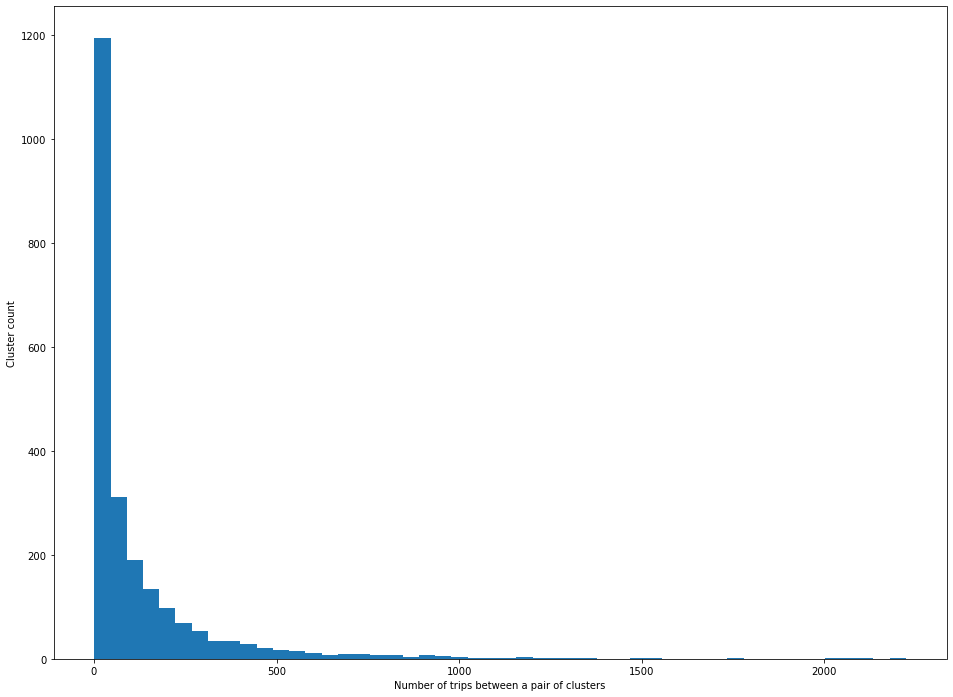

In [104]:
#plot o-d cluster pairs
#plot clusters and centroid nodes

fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter([x for x,_ in data], [y for _, y in data], c=cmap, s=3, zorder=1)

ax.scatter([x for x,_ in centroids], [y for _, y in centroids], c='red', s=50, zorder=2)
# width=0.001, length_includes_head=False, head_width=None, head_length=None,


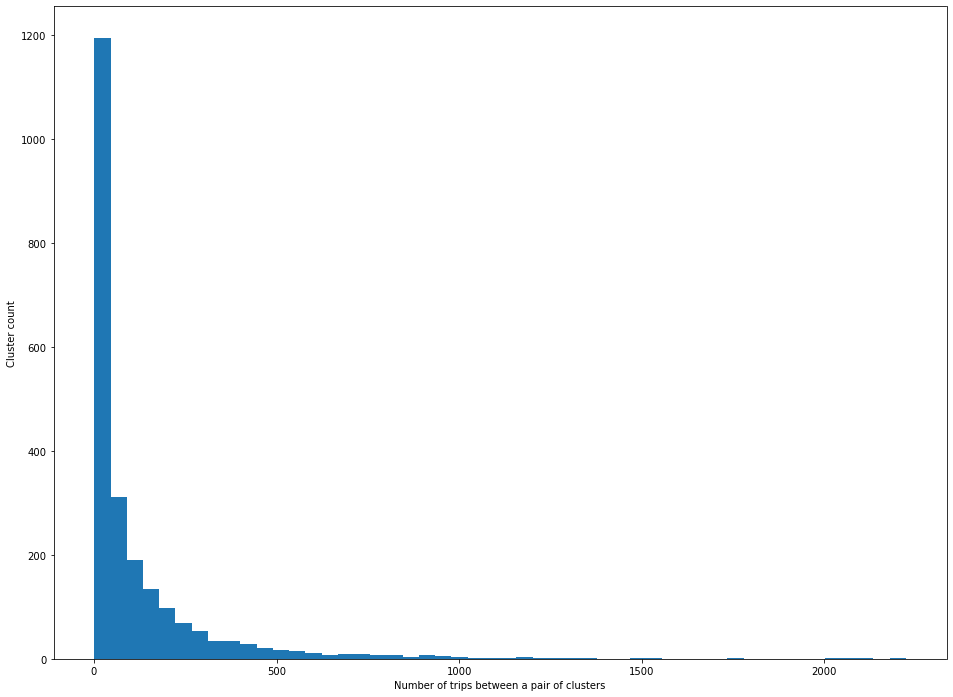

In [ ]:

# shape='full', overhang=0, head_starts_at_zero=False
arrows = np.array([counts_proj.p_x, counts_proj.p_y, counts_proj.v_x, counts_proj.v_y, counts_proj['count']]).T
num_el = arrows.shape[1]
for i in range(num_el):
    x, y, v_x, v_y, width = arrows[i,:]
    if width == 0:
        continue
    print(x, y, v_x, v_y, width )
    ax.arrow(x, y , v_x, v_y,  width = width*0.0000001, length_includes_head=False, head_width=0.005, head_length=1)

plt.show()


In [86]:
#Draw pickup and dropoff nodes heatmap
from plots import *    
    
new_df.sort_values(by=['time_ms'], inplace=True)
# print(new_df.head(5))

p_count = new_df.groupby('pickup_node').time_ms.transform('count')
d_count = new_df.groupby('dropoff_node').time_ms.transform('count')
print(p_count)
# prepare geometries (geopandas cannot have more than 1 geometry column


0           40
1          193
2           44
3           18
4           16
          ... 
286004    4093
286005    2323
286006       3
286007    1443
286008     270
Name: time_ms, Length: 286009, dtype: int64


In [ ]:

# #PLOT ORIGINS AND DESTINATIONS FOR WHOLE PERIOD
p_series = gpd.GeoDataFrame(new_df, geometry=new_df.pngeom, crs={'init': 'epsg:4326'} )
# print(p_series.head(5))
d_series = gpd.GeoDataFrame(new_df, geometry=new_df.dngeom, crs={'init': 'epsg:4326'} )
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(28,16))
plot_heatmap(p_series.geometry.x, p_series.geometry.y, axes[0])
axes[0].set_title('Pickups')

plot_heatmap(d_series.geometry.x, d_series.geometry.y, axes[1])
axes[1].set_title('Dropoffs')
plt.savefig('heatmap.png')


0           40
1          193
2           44
3           18
4           16
          ... 
286004    4093
286005    2323
286006       3
286007    1443
286008     270
Name: time_ms, Length: 286009, dtype: int64


In [ ]:
# Density heatmaps hour by hour

start = 0
hour_ms = 60*60*1e3 #1 hour
for r in range(24):
    # for c in range(cols):
    end = start + hour_ms

    df_ = new_df[(new_df['time_ms'] >= start) & (new_df['time_ms'] < end)]
    p_series = gpd.GeoDataFrame(df_, geometry=df_.pngeom, crs={'init': 'epsg:4326'} )
        # print(p_series.head(5))
    d_series = gpd.GeoDataFrame(df_, geometry=df_.dngeom, crs={'init': 'epsg:4326'} )

    psize, dsize  = len(p_series), len(d_series)
    if psize == 0 or dsize == 0:
        break
    fig, axes = plt.subplots(ncols=2, figsize=(24, 16), sharey='all', sharex='all')
    ax = axes[0]
    plot_heatmap(p_series.geometry.x, p_series.geometry.y, ax)
    ax.annotate('Pickup %02d:00-%02d:00' % (r, r+1),xy=(0.1, 1.02), xycoords='axes fraction')
    ax.annotate('%s\ntrips' % psize, xy=(0.85, 0.85), xycoords='axes fraction', fontsize=12)
    ax.tick_params(labelsize=9)
    # remove_ticks(ax)
    
    ax = axes[1]
    plot_heatmap(d_series.geometry.x, d_series.geometry.y, ax)
    ax.annotate('Dropoff %02d:00-%02d:00' % (r, r+1),xy=(0.1, 1.02), xycoords='axes fraction')
    ax.annotate('%s\ntrips' % psize, xy=(0.85, 0.85), xycoords='axes fraction', fontsize=12)
    ax.tick_params(labelsize=9)
    # remove_ticks(ax)
    start = end
    plt.savefig('demand%s_%s.png' % (r, r+1), bbox_inches='tight')
    plt.show()
    


In [33]:
#trip lengths\
def sp_length(us, vs):
    lens = []
    for u, v in zip(us, vs):
        id = G['osmid'][u]
        print(id)
        lens.append(nx.shortest_path_length(G, u, v, weight='length'))
    return lens


In [100]:
new_df['trip_len']  = new_df.apply(lambda x: sp_length(nodes_df.osmid.iloc[new_df.pickup_node.values],
                                                       nodes_df.osmid.iloc[new_df.dropoff_node.values]), axis=1)


IndexError: positional indexers are out-of-bounds

In [ ]:
from shapely.geometry import box
trips_proj = new_df.to_crs(epsg=3310)
nodes_proj = nodes_df.to_crs(epsg=3310)
bbox = box(*nodes_proj.unary_union.bounds)
centroid = bbox.centroid


In [55]:
centroid = bbox.centroid
def center_point(point):
    x = point.x - centroid.x
    y = point.y - centroid.y
    point = Point(x, y)
    return point

In [56]:
trips_proj.set_geometry('pgeom', inplace=True)
trips_proj['pgeom2']= trips_proj.pgeom.apply(lambda x: center_point(x))
trips_proj['dgeom2']= trips_proj.dgeom.apply(lambda x: center_point(x))
print(trips_proj.head())

    time_ms                 time                      pgeom  \
0   11000.0  1970-01-01 00:00:11  POINT (14.43307 50.06705)   
1   24000.0  1970-01-01 00:00:24  POINT (14.54875 50.13485)   
2   90000.0  1970-01-01 00:01:30  POINT (14.49305 50.10823)   
3  180000.0  1970-01-01 00:03:00  POINT (14.43721 50.04102)   
4  188000.0  1970-01-01 00:03:08  POINT (14.62209 50.11273)   

                             dgeom  pickup_node                     pngeom  \
0  POINT (6903685.257 7250265.677)     26231082  POINT (14.43327 50.06713)   
1  POINT (6907909.018 7257074.157)     61285013  POINT (14.54826 50.13506)   
2  POINT (6896712.015 7255414.742)     25973771  POINT (14.49305 50.10823)   
3  POINT (6899939.098 7243687.014)    245796682  POINT (14.43721 50.04102)   
4  POINT (6907822.456 7255419.741)     76012872  POINT (14.62209 50.11273)   

   dropoff_node                     pdgeom                             pgeom2  \
0      26424511  POINT (14.44869 50.06708)  POINT (-6904514.661 -725239

In [64]:
trip_vec = trips_proj[['time_ms','pgeom2', 'dgeom2']]
trip_vec['vx'] = trip_vec.apply(lambda r: r.dgeom2.x - r.pgeom2.x, axis=1)
trip_vec['vy'] = trip_vec.apply(lambda r: r.dgeom2.y - r.pgeom2.y, axis=1)
# trip_vec['vx'] = trip_vec['dgeom2'].y - trip_vec['pgeom2'].y

/home/olga/anaconda3/envs/vga/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/olga/anaconda3/envs/vga/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
print(trip_vec.head())

    time_ms                             pgeom2  \
0   11000.0  POINT (-6904514.661 -7252393.250)   
1   24000.0  POINT (-6904514.546 -7252393.183)   
2   90000.0  POINT (-6904514.601 -7252393.209)   
3  180000.0  POINT (-6904514.657 -7252393.276)   
4  188000.0  POINT (-6904514.472 -7252393.205)   

                                          dgeom2            vx            vy  
0  POINT (-843.8377952631563 -2177.640599596314)  6.903671e+06  7.250216e+06  
1    POINT (3379.923743140884 4630.839487359859)  6.907894e+06  7.257024e+06  
2   POINT (-7817.079755083658 2971.425024068914)  6.896698e+06  7.255365e+06  
3  POINT (-4589.995926958509 -8756.303633010946)  6.899925e+06  7.243637e+06  
4    POINT (3293.361254551448 2976.423210448585)  6.907808e+06  7.255370e+06  


[[array([list([-6904514.661277557, -7252393.250353062]),
       list([-6904514.545604557, -7252393.182549062]),
       list([-6904514.601303557, -7252393.209172062]), ...,
       list([-6904514.552410557, -7252393.245513062]),
       list([-6904514.667063557, -7252393.254856062]),
       list([-6904514.610025557, -7252393.243910062])], dtype=object), array([0.68958726, 0.68946899, 0.68896478, ..., 0.6893887 , 0.68966897,
       0.68963773]), array([0.7242026 , 0.72431521, 0.72479482, ..., 0.72439162, 0.72412479,
       0.72415454])]]


IndexError: pop from empty list

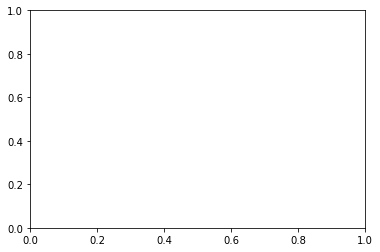

In [ ]:
trip_vec['norm'] = np.sqrt(trip_vec['vx']**2 +trip_vec['vy']**2)
trip_vec['vx'] = trip_vec['vx']/trip_vec['norm']
trip_vec['vy'] = trip_vec['vy']/trip_vec['norm']
# quiver([X, Y], U, V, [C], **kw)


[[array([list([-6904514.661277557, -7252393.250353062]),
       list([-6904514.545604557, -7252393.182549062]),
       list([-6904514.601303557, -7252393.209172062]), ...,
       list([-6904514.552410557, -7252393.245513062]),
       list([-6904514.667063557, -7252393.254856062]),
       list([-6904514.610025557, -7252393.243910062])], dtype=object), array([0.68958726, 0.68946899, 0.68896478, ..., 0.6893887 , 0.68966897,
       0.68963773]), array([0.7242026 , 0.72431521, 0.72479482, ..., 0.72439162, 0.72412479,
       0.72415454])]]


IndexError: pop from empty list

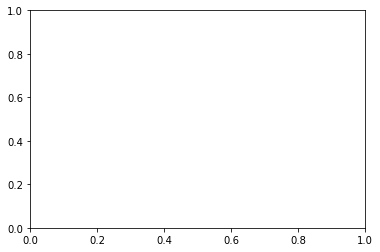

In [79]:

vectors = [[np.array(trip_vec.pgeom2.apply(lambda p: [p.x, p.y]).values), 
           np.array(trip_vec.vx.values), np.array(trip_vec.vy.values)]]
print(vectors[:][:4])
fig, ax = plt.subplots()
plt.quiver(*vectors[:10])
plt.show()
